In [1]:
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline


/Users/sachadrevet/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
def ata_forecast(series, p, q, h=1):
    """
    Computes an h-step ahead forecast using the ATA method.
    
    Parameters
    ----------
    series : array-like
        Time series data of length N. (e.g. a list or numpy array)
    p : int
        Parameter p in the ATA formulas, controlling level updates.
    q : int
        Parameter q in the ATA formulas, controlling trend updates.
    h : int, optional (default=1)
        Forecast horizon (number of steps ahead).
    
    Returns
    -------
    float
        The forecasted value at t = N for lead time h.
    """
    
    # Convert to numpy array if not already
    X = np.array(series, dtype=float)
    n = len(X)
    
    # Initialize S and T
    S = np.zeros(n)
    T = np.zeros(n)
    
    # Fill S and T with the given boundary conditions
    for t in range(n):
        if t < p:
            # For t <= p in the original notation, we simply set S[t] = X[t].
            S[t] = X[t]
        else:
            # S[t] = (p/(t+1))*X[t] + ((t+1 - p)/(t+1))*(S[t-1] + T[t-1])
            S[t] = (p/(t+1)) * X[t] + ((t+1 - p)/(t+1)) * (S[t-1] + T[t-1])
        
        if t == 0:
            # T_1 = 0 in the screenshot
            T[t] = 0.0
        elif t < q:
            # For t <= q, T[t] = X[t] - X[t-1]
            T[t] = X[t] - X[t-1]
        else:
            # T[t] = (q/(t+1))*(S[t] - S[t-1]) + ((t+1-q)/(t+1))*T[t-1]
            T[t] = (q/(t+1)) * (S[t] - S[t-1]) + ((t+1 - q)/(t+1)) * T[t-1]
    
    # Final forecast from time t = n-1 for an h-step ahead:
    #   hat{X}_n(h) = S_{n-1} + h * T_{n-1}.
    return S + h * T
    #return T


In [3]:
n=10_000_000
serie=pd.Series(np.random.normal(0,1,n))
df=pd.DataFrame({'s':serie})
df['sewm']=df['s'].ewm(halflife=20).mean()
df['ata_p20q0h1']=ata_forecast(df['s'], p=20, q=0, h=1)
df['ata_p20q5h1']=ata_forecast(df['s'], p=20, q=5, h=1)
df['ata_p20q20h1']=ata_forecast(df['s'], p=20, q=20, h=1)



<Axes: >

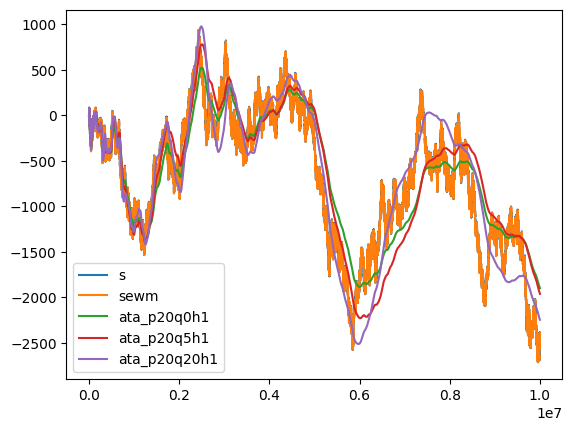

In [4]:
df.cumsum().plot()

In [5]:
df[['ata_p20q20h1']]

,ata_p20q20h1
0,-0.129799
1,0.003727
2,-1.091784
3,3.839999
4,-4.863492
...,...
9999995,-0.001445
9999996,-0.001446
9999997,-0.001449
9999998,-0.001447


In [129]:
## Holt’s additive trend method (Holt,1957)

In [ ]:
def level_forecast(series, p, q, h=1,out='trend'):
    """
    This one is probably not bad !
    """
    
    # Convert to numpy array if not already
    X = np.array(series, dtype=float)
    n = len(X)
    
    # Initialize S and T
    S = np.zeros(n)
    T = np.zeros(n)
    
    # Fill S and T with the given boundary conditions
    for t in range(1,n):
        S[t] = p * X[t] + (1 - p) * (S[t-1] + T[t-1])
        
        # T[t] = (q/(t+1))*(S[t] - S[t-1]) + ((t+1-q)/(t+1))*T[t-1]
        T[t] = q * (S[t] - S[t-1]) + (1 - q) * T[t-1]
    
    # Final forecast from time t = n-1 for an h-step ahead:
    #return S + h * T
    return S+T


<Axes: >

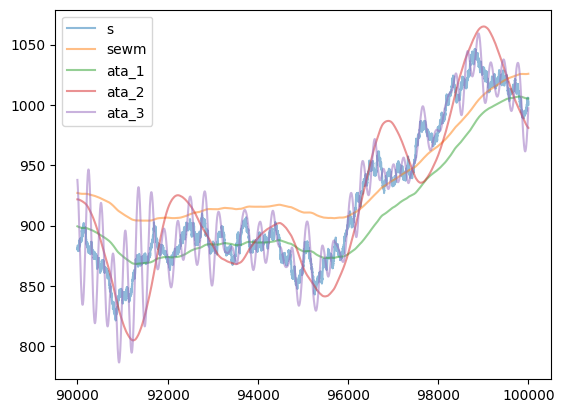

In [106]:
n=100_000
serie=pd.Series(np.random.normal(0.01,1,n))
df=pd.DataFrame({'s':serie})
df['sewm']=df['s'].ewm(halflife=1_000).mean()

p = 1e-3
q=0.0
df['ata_1']=level_forecast(df['s'], p=p, q=q, h=1,out='all')

q=0.01
df['ata_2']=level_forecast(df['s'], p=p, q=q, h=1,out='all')

q=0.5
df['ata_3']=level_forecast(df['s'], p=p, q=q, h=1,out='all')
df.cumsum().tail(10000).plot(alpha=0.5)

<Axes: >

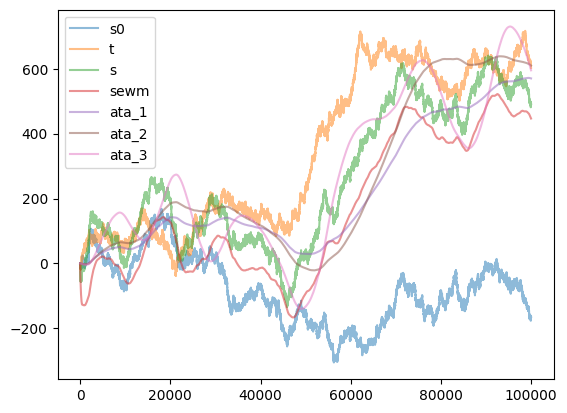

In [128]:
n=100_000
serie=pd.Series(np.random.normal(0.0,1,n))
trend=pd.Series(np.random.normal(0.01,1,n))
df=pd.DataFrame({'s0':serie,'t':trend})
df['s']=df['s0']+df['t'].ewm(halflife=1_000).mean()
df['sewm']=df['s'].ewm(halflife=1_000).mean()

p = 1e-4
q=1e-5
df['ata_1']=level_forecast(df['s'], p=p, q=q, h=1,out='all')

q=1e-4
df['ata_2']=level_forecast(df['s'], p=p, q=q, h=1,out='all')

q=1e-3
df['ata_3']=level_forecast(df['s'], p=p, q=q, h=1,out='all')
#df.cumsum().tail(15000).plot(alpha=0.5)
df.cumsum().plot(alpha=0.5)

0.7975922517725161